### Data_loading

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import pandas as pd

credit_df_scaled = pd.read_csv('./data/credit_scaled.csv')
credit_df_scaled.head()

,level_0,index,limit_balance,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,sex,...,age,default_payment_next_month,degree_graduate school,degree_high school,degree_others,degree_university,bill_amt_pca_0,pay_pca_0,pay_pca_1,pay_pca_2
0,-1.732273,-1.732011,-0.410678,-0.332002,2.939189,-0.090393,-0.008440,-0.150843,-0.158599,0.806170,...,-1.238349,0,0,0,0,1,0.042805,0.722921,-0.702588,-0.737489
1,-1.732157,-1.731895,-1.048194,-0.332338,-0.236989,-0.280829,0.062325,0.084083,-0.283917,-1.240432,...,-1.020526,0,0,0,0,1,-0.649904,6.150854,0.529218,0.639598
2,-1.732041,-1.731780,-0.888815,-0.332338,-0.236989,-0.280829,-0.206498,-0.201117,-0.204027,-1.240432,...,-0.367057,0,0,0,0,1,0.145787,5.235723,-4.098271,0.236097
3,-1.731809,-1.731433,-1.127883,-0.332338,-0.236989,-0.219674,-0.196573,-0.307461,-0.095940,-1.240432,...,-1.020526,0,0,0,0,1,-0.934077,5.821517,0.140890,1.124642
4,-1.731230,-1.730854,-1.127883,-0.332338,-0.236989,-0.280829,-0.225340,-0.229152,-0.221258,-1.240432,...,-0.475969,0,0,0,0,1,-0.863343,3.962035,-1.634116,2.364772


### Training

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [3]:
X_df = credit_df_scaled.drop(['default_payment_next_month'],axis=1)
Y_df = credit_df_scaled.default_payment_next_month

In [4]:
from sklearn.model_selection import train_test_split

X = X_df.values
y = Y_df.values.flatten()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [27]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

###  Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

In [19]:
def test(x_train, y_train):
    
    # stohastic gradient
    from sklearn.model_selection import GridSearchCV
    

    model1 = SGDClassifier(random_state = 45)

    #params
    param_grid = {"max_iter": [10, 50, 100, 1000],
                  "alpha": [0.001, 0.01, 0.1, 1],
                  "penalty": ["l1", "l2", "none"]}

    # run grid search
    model1 = GridSearchCV(model1, param_grid=param_grid, scoring='roc_auc')
    model1.fit(x_train, y_train)

    print(f'Best params = {model1.best_params_}')

    # simple gradient
    model2 = LogisticRegression(random_state = 45)
    gs_values = {'penalty': ['l1', 'l2'], 'C':[1, 2, 5, 10, 15]}
    model2 = GridSearchCV(model2, param_grid=gs_values, scoring='roc_auc')
    model2.fit(x_train, y_train)
    print(f'Best params = {model2.best_params_}')
    return model1, model2

In [20]:
sgd_model, log_reg_moddel = test(x_train, y_train)

Best params = {'alpha': 0.1, 'max_iter': 10, 'penalty': 'l2'}
Best params = {'C': 15, 'penalty': 'l2'}


### XGBOOST

In [28]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 5, 8, 12]
#         }

params = {
        'min_child_weight': [1],
        'gamma': [0.5, 0.3],
        'subsample': [0.8],
        'colsample_bytree': [1.0],
        'max_depth': [12, 15]
        }
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, tree_method='gpu_hist', gpu_id=0)

In [29]:
from sklearn.model_selection import GridSearchCV
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 45)

random_search = GridSearchCV(xgb,
                             param_grid=params,
                             scoring='roc_auc',
                             n_jobs=8,
                             cv=skf.split(x_train,y_train),
                             verbose=3
                            )

# train
start_time = timer(None) 
random_search.fit(x_train, y_train)
timer(start_time) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 out of  20 | elapsed:  1.4min remaining:   57.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  1.9min finished



 Time taken: 0 hours 1 minutes and 59.96 seconds.


In [39]:
from sklearn.externals import joblib

joblib.dump(random_search.best_estimator_, 'GS_obj_1_1.pkl')
# best_estimator = joblib.load('GS_obj_1_1.pkl')

['GS_obj_1_1.pkl']

## ANN

In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import random
import os

import warnings
warnings.filterwarnings('ignore')

In [8]:
def set_seed():
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
class MyDataset(Dataset):
    
    def __init__(self, X, y):

        """ 
          Data loader  with tranforming, 
          preparing  to feed CNN by Torch lib
        """     
        self.data = X
        self.target = y
    
    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        
        target = int(self.target[idx])
        input_data = torch.from_numpy(self.data[idx])
        
        return input_data, target

In [11]:
x_train = x_train.astype(np.float32)
# y_train = y_train.astype(np.int32)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

train_dataset = MyDataset(x_train, y_train)
test_dataset = MyDataset(x_test, y_test)

train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          num_workers=0,
                          shuffle=False)

test_loader = DataLoader(test_dataset,
                          batch_size=256,
                          num_workers=0,
                          shuffle=False)

sizes = {'train': len(train_dataset), 
         'test': len(test_dataset)}
         
loaders = {'train': train_loader, 'test': test_loader}

In [12]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=20):
        """
          Define your NN here. Implement an ability to use different activations.

          Args:
            activation: {sigmoid, relu, tanh} default sigmoid. 
              Defines which activation function to use.
            hidden_size: default 64
              Defines the size of hidden layer.
        """

        super(NeuralNetwork, self).__init__()


        self.input_layer = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout()

        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout()

        self.output_layer = nn.Linear(hidden_size, output_size)


    def forward(self, X):
        """
          Forward propagation of your NN (inference).

          Args:
            X: input data
          Returns
            output: nn's raw output (logits)
            probs: probabilities of classes by softmax function
        """

        output = self.input_layer(X)  
        output = self.relu1(output) 
        output = self.dropout1(output)

        output = self.hidden_layer(output)
        output = self.relu2(output)         
        output = self.dropout2(output)    

        output = self.output_layer(output)

        return output

In [13]:
set_seed()
ann_model = NeuralNetwork(len(train_dataset[0][0]), 2, hidden_size=20)
ann_model.to(device)

NeuralNetwork(
  (input_layer): Linear(in_features=20, out_features=20, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (hidden_layer): Linear(in_features=20, out_features=20, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)

In [14]:
def eval_model(model, loader, criterion, phase):
    model.eval()
    
    avg_loss = 0
    acc = 0
    
    for data, target in loader: 
        data = data.to(device)
        target = target.to(device)
        
        with torch.no_grad():
            logits = model(data)
        
        loss = criterion(logits, target)
        
        avg_loss += loss.item()
        acc += (logits.argmax(1) == target).sum().item()
        
    avg_loss /= len(loaders[phase])
    acc /=  sizes[phase]

    print('  {} phase:'.format(phase))
    print('    Loss: {0:.5}'.format(avg_loss))
    print('    Acc: {0:.5}'.format(acc))

In [15]:
def train_model(model, train_loader, test_loader, num_epochs, checkpoint_step, eval_step, criterion, optimizer):
    """
    Training loop.
    """
    for epoch in range(num_epochs):

        for data, target in train_loader:
            data = data.to(device)     
            target = target.to(device)

            optimizer.zero_grad() 
                                    

            logits = model(data)

            loss = criterion(logits, target) 

            loss.backward()
            optimizer.step()

        if epoch % eval_step == 0 or epoch == num_epochs - 1: 
            print('{} epoch:'.format(epoch))
            eval_model(model, test_loader, criterion, 'test')
            eval_model(model, train_loader, criterion,'train')

        if epoch % checkpoint_step == 0 or epoch == num_epochs - 1:
            print('Saving model_ann-{}.pt...'.format(epoch))
            torch.save(model, 'models/model_ann-{}.pt'.format(epoch))

    return model

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ann_model.parameters(), lr=0.01)

eval_model(ann_model, test_loader, criterion, 'test')

  test phase:
    Loss: 0.6987
    Acc: 0.46136


In [17]:
ann_model = train_model(ann_model, train_loader, test_loader, 2000, 200, 200, criterion, optimizer)

0 epoch:
  test phase:
    Loss: 0.68187
    Acc: 0.5605
  train phase:
    Loss: 0.68114
    Acc: 0.56294
Saving model_ann-0.pt...
200 epoch:
  test phase:
    Loss: 0.56905
    Acc: 0.6969
  train phase:
    Loss: 0.55102
    Acc: 0.70986
Saving model_ann-200.pt...
400 epoch:
  test phase:
    Loss: 0.56447
    Acc: 0.70082
  train phase:
    Loss: 0.54486
    Acc: 0.71359
Saving model_ann-400.pt...
600 epoch:
  test phase:
    Loss: 0.5613
    Acc: 0.70524
  train phase:
    Loss: 0.5404
    Acc: 0.71785
Saving model_ann-600.pt...
800 epoch:
  test phase:
    Loss: 0.55937
    Acc: 0.70573
  train phase:
    Loss: 0.53699
    Acc: 0.71982
Saving model_ann-800.pt...
1000 epoch:
  test phase:
    Loss: 0.5592
    Acc: 0.70739
  train phase:
    Loss: 0.53408
    Acc: 0.72364
Saving model_ann-1000.pt...
1200 epoch:
  test phase:
    Loss: 0.55986
    Acc: 0.7072
  train phase:
    Loss: 0.5316
    Acc: 0.7257
Saving model_ann-1200.pt...
1400 epoch:
  test phase:
    Loss: 0.55962
    A

In [179]:
# ann_model(torch.from_numpy(x_test[1]).to(device)).argmax(0).item()

## Accuracy

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(y_test, y_pred):
    import mlxtend
    from mlxtend.plotting import plot_confusion_matrix
    CM = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(3, 3))
    plt.title("Default (0 - no, 1 - yes)")
    plt.show()

def report(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))
    confusion_matrix_plot(y_test, y_pred)    

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      4482
           1       0.69      0.70      0.70      5716

    accuracy                           0.66     10198
   macro avg       0.65      0.65      0.65     10198
weighted avg       0.66      0.66      0.66     10198



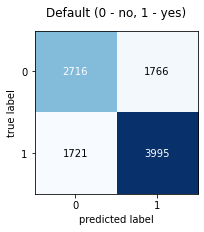

In [42]:
'''
SGD
'''
report(sgd_model, x_test, y_test)

              precision    recall  f1-score   support

           0       0.61      0.58      0.59      4482
           1       0.68      0.71      0.70      5716

    accuracy                           0.65     10198
   macro avg       0.65      0.65      0.65     10198
weighted avg       0.65      0.65      0.65     10198



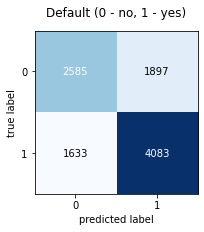

In [43]:
'''
Logistic Regression
'''
report(log_reg_moddel, x_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      4482
           1       0.90      1.00      0.95      5716

    accuracy                           0.94     10198
   macro avg       0.95      0.93      0.93     10198
weighted avg       0.94      0.94      0.93     10198



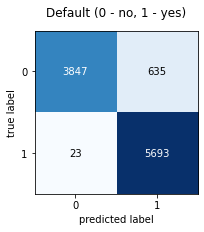

In [40]:
'''
XGBOOST
'''
report(random_search, x_test, y_test)

              precision    recall  f1-score   support

           0       0.68      0.63      0.65      4482
           1       0.72      0.77      0.74      5716

    accuracy                           0.71     10198
   macro avg       0.70      0.70      0.70     10198
weighted avg       0.70      0.71      0.70     10198



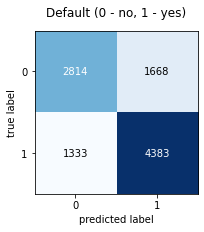

In [186]:
'''
ANN
'''
y_pred = ann_model(torch.from_numpy(x_test).to(device)).cpu().data.numpy().argmax(1)
print(classification_report(y_test, y_pred))
confusion_matrix_plot(y_test, y_pred)    

##### The best is XGBOOST

In [44]:
print(random_search.best_estimator_)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, gpu_id=0,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=False,
              verbosity=None)
